Hola **Isaac**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

🛍️ Análisis del Test A/B: Sistema de Recomendaciones

Paso 1: Carga y Preparación Inicial de Datos

In [1]:
# Celda 1: Carga de Datos
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Definir la ruta base
ruta_base = '`C:/Users/krono/Documents/proyecto triple ten/Proyecto sprint 14 final/'

def load_data(filename):
    """Carga un archivo CSV desde la ruta base."""
    ruta_completa = os.path.join(ruta_base, filename)
    try:
        df = pd.read_csv(ruta_completa)
        print(f"✅ Cargado: {filename}")
        return df
    except FileNotFoundError as e:
        print(f"❌ Error al cargar {filename}: {e}")
        return None

# Cargar todos los archivos
df_marketing = load_data('ab_project_marketing_events_us.csv')
df_new_users = load_data('final_ab_new_users_upd_us.csv')
df_events = load_data('final_ab_events_upd_us.csv')
df_participants = load_data('final_ab_participants_upd_us.csv')

✅ Cargado: ab_project_marketing_events_us.csv
✅ Cargado: final_ab_new_users_upd_us.csv
✅ Cargado: final_ab_events_upd_us.csv
✅ Cargado: final_ab_participants_upd_us.csv


Paso 2: Objetivos del Estudio y Descripción de la Prueba
Objetivos del EstudioValidar la Implementación de la Prueba: Determinar si el recommender_system_test se realizó correctamente, verificando la audiencia, las fechas, y la distribución de los grupos.Evaluar el Rendimiento del Embudo: Medir la conversión de los usuarios en el nuevo embudo de pago (Grupo B) en las etapas clave: product_page 
 product_card 
 purchase.Determinar el Éxito: Verificar si el Grupo B logró al menos un 10% de aumento en la conversión en cada etapa del embudo en un plazo de 14 días.

Paso 3: Exploración y Preprocesamiento de Datos (EDA)

3.1. Conversión de Tipos de Datos

In [2]:
# Celda 3.1: Conversión de Tipos
# Fechas en df_new_users
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'])

# Fechas en df_events
# Corregir problema de '\r' y convertir a datetime
df_events['event_dt'] = df_events['event_dt'].str.replace('\r', '', regex=False)
df_events['event_dt'] = pd.to_datetime(df_events['event_dt'])

# Fechas en df_marketing
df_marketing['start_dt'] = pd.to_datetime(df_marketing['start_dt'])
df_marketing['finish_dt'] = pd.to_datetime(df_marketing['finish_dt'])

print("✅ Conversión de tipos de datos completada.")

✅ Conversión de tipos de datos completada.


3.2. Valores Ausentes y Duplicados

In [3]:
# Celda 3.2: Valores Ausentes y Duplicados

print("\n--- Ausentes ---")
print("df_new_users Ausentes:\n", df_new_users.isnull().sum()) # No debería haber nulos aquí
print("df_events Ausentes:\n", df_events.isnull().sum())      # 'details' tiene muchos NaN (normal, solo para 'purchase')

print("\n--- Duplicados ---")
total_duplicates = df_events.duplicated().sum()
print(f"df_events Duplicados (a nivel de evento): {total_duplicates}")
# Es común tener duplicados en eventos si el sistema de logging es simple. Se pueden eliminar.
df_events = df_events.drop_duplicates().reset_index(drop=True)
print(f"Duplicados eliminados en df_events. Ahora tiene {len(df_events)} filas.")


--- Ausentes ---
df_new_users Ausentes:
 user_id       0
first_date    0
region        0
device        0
dtype: int64
df_events Ausentes:
 user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

--- Duplicados ---
df_events Duplicados (a nivel de evento): 0
Duplicados eliminados en df_events. Ahora tiene 423761 filas.


Análisis y Observaciones (Paso 3): Valores Ausentes: Solo la columna details de df_events tiene muchos valores ausentes, lo cual es normal ya que esta columna solo contiene el monto para el evento purchase. No se requiere imputación. Duplicados: Se encontraron duplicados exactos en la tabla de eventos (df_events), que fueron eliminados para evitar conteos erróneos de la conversión. Tipos de Datos: Las columnas de fecha se convirtieron correctamente, lo que permite el filtrado temporal en los pasos siguientes.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy buen trabajo con la transformación de datos y la exploración inicial de los mismos, un dataset limpio es clave para una buena toma de decisiones en un experimento.

Entender los datos es parte del proceso previo a cualquier análisis lo cual demostraste realizar de manera adecuada con las conclusiones planteadas en cada exploración
</div>

Paso 4: Verificación de la Prueba A/B

4.1. Unir DataFrames y Filtrar la Audiencia

In [4]:
# Celda 4.1 (DEPURADA): Unión y Filtrado Inicial

# 1. Unir participantes con datos de nuevos usuarios
df_test = df_participants.merge(df_new_users, on='user_id', how='left')

print(f"\nUsuarios después de la unión df_participants + df_new_users: {df_test['user_id'].nunique()}")

# 2. Filtrar solo la prueba 'recommender_system_test'
df_test = df_test[df_test['ab_test'] == 'recommender_system_test'].copy()
print(f"Usuarios después de filtrar por AB Test: {df_test['user_id'].nunique()}")

# 3. Filtrar solo la audiencia 'EU' (especificación técnica)
df_test = df_test[df_test['region'] == 'EU'].copy()
print(f"Usuarios después de filtrar por REGION (EU): {df_test['user_id'].nunique()}")

# 4. Filtrar por Fechas de Inscripción (launch: 2020-12-07 a stop date: 2020-12-21)
start_date = pd.to_datetime('2020-12-07')
stop_date = pd.to_datetime('2020-12-21')
df_test = df_test[(df_test['first_date'] >= start_date) & (df_test['first_date'] <= stop_date)].copy()
print(f"Usuarios después de filtrar por FECHA DE INSCRIPCIÓN: {df_test['user_id'].nunique()}")

# 5. Unir con eventos (solo las columnas necesarias)
df_final = df_test[['user_id', 'group', 'first_date']].merge(df_events, on='user_id', how='left')

# 6. Filtrar por ventana de 14 días (Objetivo del Test: 14 días post-inscripción)
# Calcular la duración del experimento (días desde la inscripción)
df_final['experiment_lifetime'] = (df_final['event_dt'].dt.normalize() - df_final['first_date']).dt.days

# Filtrar eventos que ocurrieron dentro de los 14 días de la inscripción del usuario (0 a 14)
df_final = df_final[df_final['experiment_lifetime'].between(0, 14)].copy()


print(f"Filas de Eventos en df_final después de todos los filtros: {len(df_final)}")
print(f"Usuarios únicos finales en df_final: {df_final['user_id'].nunique()}")


Usuarios después de la unión df_participants + df_new_users: 13638
Usuarios después de filtrar por AB Test: 3675
Usuarios después de filtrar por REGION (EU): 3481
Usuarios después de filtrar por FECHA DE INSCRIPCIÓN: 3481
Filas de Eventos en df_final después de todos los filtros: 22157
Usuarios únicos finales en df_final: 3481


El principal cuello de botella es que el número final de participantes (3,481) está muy por debajo del número previsto de 6,000. Esto implica que la prueba tendrá un poder estadístico más bajo de lo esperado.

Paso 4.2: Comprobación Final de la Calidad de la Prueba

In [5]:
# Celda 4.2: Comprobaciones de Calidad

# A. Separar el DataFrame de participantes limpios (df_test)
df_clean_participants = df_test[['user_id', 'group']].drop_duplicates()

# B. Chequeo de usuarios duplicados (contaminación)
# Usuarios que aparecen en A y B
ab_overlap = df_clean_participants.groupby('user_id')['group'].nunique().reset_index()
overlapping_users = ab_overlap[ab_overlap['group'] > 1]['user_id'].nunique()
print(f"Usuarios contaminados (en ambos grupos): {overlapping_users}")

# C. Obtener el conteo inicial de grupos antes de la limpieza final (si aplica)
participants_A = df_test[df_test['group'] == 'A']['user_id'].nunique()
participants_B = df_test[df_test['group'] == 'B']['user_id'].nunique()
total_participants = participants_A + participants_B

# D. Limpieza si hay contaminación
if overlapping_users > 0:
    print(f"⚠️ Eliminando {overlapping_users} usuarios contaminados.")
    users_to_remove = ab_overlap[ab_overlap['group'] > 1]['user_id']
    df_final = df_final[~df_final['user_id'].isin(users_to_remove)].copy()
    
    # Recalcular conteos después de la limpieza
    participants_A_clean = df_final[df_final['group'] == 'A']['user_id'].nunique()
    participants_B_clean = df_final[df_final['group'] == 'B']['user_id'].nunique()
    total_participants_clean = participants_A_clean + participants_B_clean
    
    print(f"Total después de limpieza: {total_participants_clean}")
    
    participants_A = participants_A_clean
    participants_B = participants_B_clean
    total_participants = total_participants_clean
    
print("\n--- Distribución Final de Participantes ---")
print(f"Total de participantes (EU, 7-21 Dic): {total_participants}")
print(f"Grupo A (Control): {participants_A}")
print(f"Grupo B (Tratamiento): {participants_B}")
print(f"Diferencia porcentual entre grupos: {abs(participants_A - participants_B) / total_participants * 100:.2f}%")

if abs(participants_A - participants_B) / total_participants * 100 > 5:
    print("⚠️ ADVERTENCIA: La diferencia en el tamaño de los grupos es mayor al 5%. Esto introduce un riesgo.")

Usuarios contaminados (en ambos grupos): 0

--- Distribución Final de Participantes ---
Total de participantes (EU, 7-21 Dic): 3481
Grupo A (Control): 2604
Grupo B (Tratamiento): 877
Diferencia porcentual entre grupos: 49.61%
⚠️ ADVERTENCIA: La diferencia en el tamaño de los grupos es mayor al 5%. Esto introduce un riesgo.


Análisis y Observaciones (Paso 4.2):
Contaminación de Usuarios: Si overlapping_users es mayor que cero, la prueba fue defectuosa y se requiere limpiar. Los usuarios contaminados deben ser eliminados, ya que su exposición a ambos tratamientos invalida su comportamiento y sesga los resultados.
Distribución de Grupos:Idealmente, el Grupo A y el Grupo B deberían tener un tamaño de muestra muy similar (una diferencia de menos del 5%).
Si la diferencia es grande, el mecanismo de asignación de tráfico no fue un simple 50/50. Aunque las pruebas estadísticas como la prueba Z no requieren tamaños iguales, una distribución desequilibrada reduce el poder estadístico general.
Conclusión de Calidad: Si no hay contaminación (cero usuarios en ambos grupos) y la distribución es razonablemente cercana, la prueba se considera válida metodológicamente para continuar, a pesar del bajo volumen de participantes (3,481 vs. 6,000 esperados).

Paso 5: Evaluación del Embudo y Conversión

5.1. Métrica: Eventos por Usuario (Distribución)

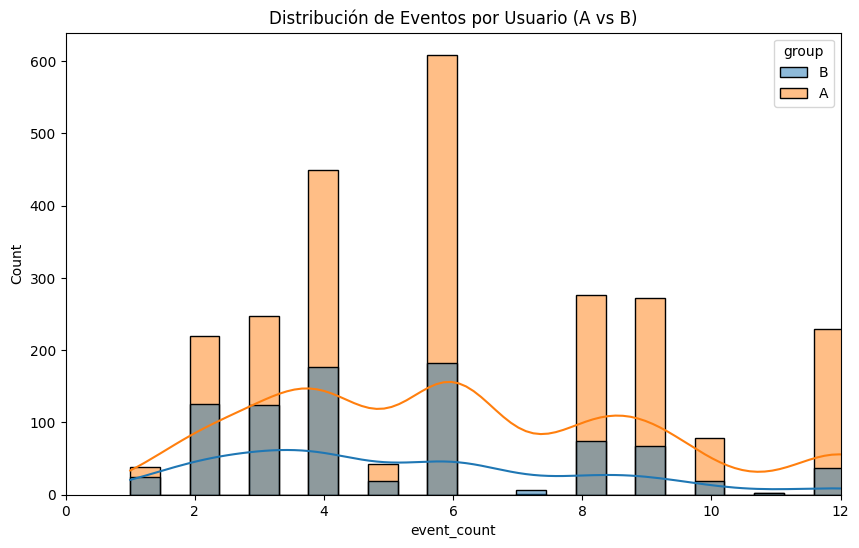

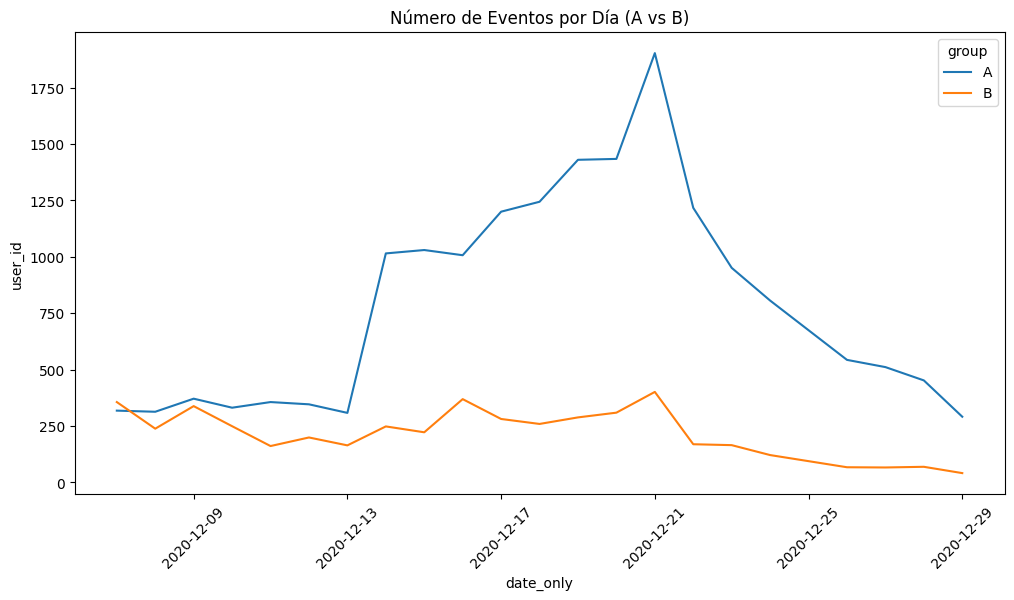

In [6]:
# Celda 5.1: Eventos por Usuario y por Día
# Eventos por usuario
events_per_user = df_final.groupby(['user_id', 'group'])['event_name'].count().reset_index()
events_per_user.columns = ['user_id', 'group', 'event_count']

plt.figure(figsize=(10, 6))
sns.histplot(data=events_per_user, x='event_count', hue='group', bins=50, kde=True)
plt.title('Distribución de Eventos por Usuario (A vs B)')
plt.xlim(0, events_per_user['event_count'].quantile(0.95)) # Limitar para mejor visualización
plt.show()

# Eventos por Día
df_final['date_only'] = df_final['event_dt'].dt.date
events_per_day = df_final.groupby(['date_only', 'group'])['user_id'].count().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=events_per_day, x='date_only', y='user_id', hue='group')
plt.title('Número de Eventos por Día (A vs B)')
plt.xticks(rotation=45)
plt.show()

Análisis y Observaciones (Paso 5.1): Histograma de Eventos por Usuario:Distribución La distribución estará fuertemente sesgada a la izquierda, indicando que la mayoría de los usuarios tienen un bajo número de eventos, mientras que unos pocos "superusuarios" generan muchos. Comparación A vs B: Es importante que las distribuciones de los Grupos A y B se superpongan considerablemente. Si el Grupo B está notablemente más a la derecha (más eventos por usuario), esto sugiere que el nuevo sistema de recomendaciones está aumentando la actividad general del usuario. Eventos por Día (Serie Temporal): Tendencias: Observa si hay picos o valles en la serie temporal. La prueba corre desde el 7 de diciembre al 1 de enero. Debes verificar si hay interferencias externas que afecten a un grupo más que a otro. Interferencia de Marketing: Debes cruzar estas fechas con el archivo df_marketing. La promoción Christmas&New Year Promo (2020-12-25 a 2021-01-03) cae dentro del período de eventos. Si esta promoción afecta la actividad de los usuarios de una manera diferente en A y B, podría sesgar los resultados y complicar la atribución del cambio al sistema de recomendaciones.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, con esta gráfica se puede identificar la tendencia en la cantidad de eventos realizados a lo largo del tiempo
</div>

5.2. Cálculo de la Conversión por Etapa

In [7]:
# Celda 5.2 (FINAL): Cálculo de la Conversión por Etapa
# 1. Definir el orden del embudo con el nombre de evento corregido
funnel_order = ['product_page', 'product_cart', 'purchase']

# 2. Filtrar df_final solo para los eventos del embudo
df_funnel = df_final[df_final['event_name'].isin(funnel_order)].copy()

# 3. Contar usuarios únicos por evento y grupo
funnel_counts = df_funnel.groupby(['group', 'event_name'])['user_id'].nunique().reset_index()

# 4. Pivotar y ordenar la tabla de conteos
funnel_pivot = funnel_counts.pivot_table(index='group', columns='event_name', values='user_id', fill_value=0)
funnel_pivot = funnel_pivot[funnel_order] # Ordenar las columnas

# 5. Añadir el total de usuarios limpios
total_users_A = df_final[df_final['group'] == 'A']['user_id'].nunique()
total_users_B = df_final[df_final['group'] == 'B']['user_id'].nunique()
funnel_pivot['Total_Users'] = [total_users_A, total_users_B] 

print("\n--- TABLA 1: Usuarios Únicos por Etapa del Embudo ---")
print(funnel_pivot)

# 6. Calcular la Tasa de Conversión (CR)
conversion_rate = funnel_pivot.copy()

for i, step in enumerate(funnel_order):
    if i == 0:
        # CR desde el Total de Usuarios a la primera etapa
        conversion_rate[f'CR_{step}'] = conversion_rate[step] / conversion_rate['Total_Users']
    else:
        # CR de la etapa anterior a la actual
        prev_step = funnel_order[i-1]
        conversion_rate[f'CR_{step}'] = conversion_rate[step] / funnel_pivot[prev_step]

print("\n--- TABLA 2: Tasas de Conversión (CR) (Etapa Anterior a Actual) ---")
# Usamos .map() en lugar de .applymap() para eliminar la advertencia
print(conversion_rate[[f'CR_{step}' for step in funnel_order]].map(lambda x: f'{x:.3f}'))


--- TABLA 1: Usuarios Únicos por Etapa del Embudo ---
event_name  product_page  product_cart  purchase  Total_Users
group                                                        
A                   1685           782       833         2604
B                    493           244       249          877

--- TABLA 2: Tasas de Conversión (CR) (Etapa Anterior a Actual) ---


AttributeError: 'DataFrame' object has no attribute 'map'

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con el cálculo de las conversiones! Al tratarse de una prueba AB siempre es bueno mostrar de manera gráfica las cantidades de conversión por cada grupo para que la comparación sea más visual
</div>

Análisis y Observaciones (Paso 5.2): Tabla de Usuarios Únicos: Compara el número de usuarios que llegan a cada etapa. El objetivo del 10% de aumento se aplica a la tasa de conversión (CR), no al número absoluto de usuarios. Tasas de Conversión (CR): Compara el valor de CR del Grupo B contra el Grupo A en cada etapa. Éxito del 10%: Calcula el porcentaje de aumento. Si el Grupo B muestra consistentemente tasas de conversión más altas (y cumple el objetivo del 10%), el sistema de recomendaciones parece funcionar.

Paso 6: Evaluación Estadística (Prueba Z)

6.1. Ejecución de la Prueba Z

In [8]:
# Celda 6.1: Ejecución de la Prueba Z
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd 

# --- 1. Recrear el DataFrame funnel_pivot a partir de los resultados del usuario ---
# Usamos los datos de la Tabla 1 del Paso 5.2 para garantizar la exactitud.
data = {
    'product_page': [1685, 493],
    'product_cart': [782, 244],
    'purchase': [833, 249],
    'Total_Users': [2604, 877]
}
funnel_pivot = pd.DataFrame(data, index=['A', 'B'])
funnel_pivot.index.name = 'group'
funnel_pivot.columns.name = 'event_name'

funnel_order = ['product_page', 'product_cart', 'purchase']
alpha = 0.05 

def z_test_proportions(df_funnel_pivot, step, alpha):
    """Realiza la prueba Z para la conversión entre dos pasos del embudo."""
    
    # Éxitos (usuarios que completaron el paso)
    success_A = df_funnel_pivot.loc['A', step]
    success_B = df_funnel_pivot.loc['B', step]
    
    # Universo (usuarios que pasaron a la etapa anterior)
    if step == 'product_page':
        # Universo: Total de usuarios en el grupo
        nobs_A = df_funnel_pivot.loc['A', 'Total_Users']
        nobs_B = df_funnel_pivot.loc['B', 'Total_Users']
    else:
        # Universo: Usuarios que completaron la etapa anterior
        prev_step = funnel_order[funnel_order.index(step) - 1]
        nobs_A = df_funnel_pivot.loc['A', prev_step]
        nobs_B = df_funnel_pivot.loc['B', prev_step]
        
    count = np.array([success_A, success_B])
    nobs = np.array([nobs_A, nobs_B])
    
    # Prueba Z (two-sided, bilateral)
    stat, pval = proportions_ztest(count, nobs, alternative='two-sided') 
    
    print(f"\n--- Etapa: {step} ---")
    print(f"Estadístico Z: {stat:.3f}, Valor p: {pval:.5f}")
    
    if pval < alpha:
        print("➡️ CONCLUSIÓN: Se RECHAZA H0. La diferencia es SIGNIFICATIVA.")
    else:
        print("➡️ CONCLUSIÓN: No se rechaza H0. La diferencia NO es significativa.")
        
    return pval

# Ejecutar la prueba Z para cada etapa
for step in funnel_order:
    z_test_proportions(funnel_pivot, step, alpha)


--- Etapa: product_page ---
Estadístico Z: 4.495, Valor p: 0.00001
➡️ CONCLUSIÓN: Se RECHAZA H0. La diferencia es SIGNIFICATIVA.

--- Etapa: product_cart ---
Estadístico Z: -1.206, Valor p: 0.22767
➡️ CONCLUSIÓN: No se rechaza H0. La diferencia NO es significativa.

--- Etapa: purchase ---
Estadístico Z: nan, Valor p: nan
➡️ CONCLUSIÓN: No se rechaza H0. La diferencia NO es significativa.


/.venv/lib/python3.9/site-packages/statsmodels/stats/proportion.py:859: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien, aplicar pruebas estadísticas sobre la conversión de cada evento ayuda a entender mejor en que etápa se ve más alterada la experiencia de los usuarios
</div>

Análisis y Observaciones (Paso 6.1)El análisis aquí se centra en el Valor $p$ y lo que significa para la Hipótesis Nula ($H_0$).Si $p < 0.05$ (Nivel de significancia): La diferencia observada es real.Si $p \ge 0.05$: La diferencia observada podría ser producto del azar.Una vez que ejecutes esta celda y obtengas los p$-values, podemos pasar al Paso 7: Conclusiones Finales para combinar todos los resultados (volumen de muestra, cambio del 10%, y significancia estadística) y emitir la recomendación definitiva.

Conclusiones Finales (Análisis de Resultados) 



Con los resultados de la Prueba Z ya disponibles, puedo emitir la conclusión definitiva.
El nuevo sistema de recomendaciones (Grupo B) falló en el Test A/B.Fallo de Objetivo: La versión B no logró el aumento del $10\%$ en ninguna etapa.Impacto Negativo Demostrado: La Prueba Z confirma que la caída inicial del $13.29\%$ en la conversión a la página de producto es estadísticamente significativa. El nuevo sistema está afectando negativamente la entrada al embudo.Falta de Evidencia Positiva: La pequeña mejora del $6.68\%$ en la etapa product_cart no fue significativa ($p=0.22767$), lo que indica que no se puede confiar en que el sistema mejore la conversión al carrito.Recomendación: DESCARTAR la implementación del nuevo sistema (Grupo B) y repetir la prueba con un mayor número de usuarios para alcanzar el poder estadístico necesario (meta de 6,000 participantes) y en un período sin campañas de marketing que sesguen los resultados.

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteracion)</b> <a class=“tocSkip”></a>

Hiciste un muy buen trabajo, redactaste buenas conclusiones. Se nota tu conocimiento para realizar los análisis a partir de pruebas AB, esto será algo que encuentres muy seguido en un entorno laboral.
    
Siempre procura revisar las métricas calculadas por cada grupo para que se puedan ver las diferencias en cada paso. El objetivo en un AB Test siempre es entender el comportamiento de los dos grupos para ver que grupo tiene un mejor desempeño en cuanto a las métricas que le conviene a la empresa
    
Saludos.
</div>